# data import  

In [1]:
import pandas as pd
import numpy as np


In [2]:
# read csv file
tickers = ['006400', '018260', '022100', '307950', '286940', '272210', '035510', '069960', '005930', '035420', '003550', '034730', '035720', '000660', '030200', '005380', '005490']

# for ticker in tickers:
#     df_csv = pd.read_csv('./add_target/{ticker}.csv'.format(ticker = ticker))

df_csv = pd.read_csv('./add_target/006400.csv')
df_csv

,Date,Open,High,Low,Close,Volume,Change,RSI,Stochastic RSI,Target
0,2018-01-18,218500,223500,216000,218000,378700,0.016317,66.400000,1.000000,1
1,2018-01-19,218000,220500,202000,204000,969072,-0.064220,49.640288,0.199840,1
2,2018-01-22,202000,205000,198000,203000,580327,-0.004902,42.857143,0.000000,1
3,2018-01-23,204000,205000,199500,201000,608934,-0.009852,44.628099,0.075223,0
4,2018-01-24,207500,210500,204500,208000,645722,0.034826,49.624060,0.287430,0
...,...,...,...,...,...,...,...,...,...,...
1625,2024-08-26,334000,338500,329000,332000,295574,0.004539,63.207547,1.000000,0
1626,2024-08-27,332500,346000,328500,338000,417485,0.018072,60.000000,0.902877,0
1627,2024-08-28,343500,350500,337000,339500,562530,0.004438,62.176166,0.968770,0
1628,2024-08-29,339000,362500,338000,358500,759750,0.055965,77.073171,1.000000,1


# global boundary

In [3]:
from easydict import EasyDict as edict

args = edict({
    'random_state': 42,
    'test_size': 0.2,
    'n_estimators': 100
})

# data preprocessing

## data encoding

### Separated into year, month, and day

In [4]:
# Date - 년, 월, 일로 분할
df_csv["Date"] = pd.to_datetime(df_csv["Date"])
df_csv["year"] = df_csv["Date"].dt.year
df_csv["month"] = df_csv["Date"].dt.month
df_csv["day"] = df_csv["Date"].dt.day

df_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630 entries, 0 to 1629
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            1630 non-null   datetime64[ns]
 1   Open            1630 non-null   int64         
 2   High            1630 non-null   int64         
 3   Low             1630 non-null   int64         
 4   Close           1630 non-null   int64         
 5   Volume          1630 non-null   int64         
 6   Change          1630 non-null   float64       
 7   RSI             1630 non-null   float64       
 8   Stochastic RSI  1630 non-null   float64       
 9   Target          1630 non-null   int64         
 10  year            1630 non-null   int32         
 11  month           1630 non-null   int32         
 12  day             1630 non-null   int32         
dtypes: datetime64[ns](1), float64(3), int32(3), int64(6)
memory usage: 146.6 KB


### Separated into 4 quarters

In [5]:
# Date - 분기 별로 분할
df_csv['Quarter'] = df_csv['Date'].dt.quarter

# 분기 정보를 문자열로 변환
df_csv['Quarter_str'] = df_csv['Quarter'].astype(str)

# one-hot encoding을 적용
df_csv_encoded = pd.get_dummies(df_csv['Quarter_str'], prefix='Quarter')

# 원래 데이터 프레임과 one-hot encoding된 데이터 프레임을 결합
df_csv = pd.concat([df_csv, df_csv_encoded], axis=1)

# 불필요한 칼럼 제거 (옵션)
df_csv = df_csv.drop(columns=['Quarter', 'Quarter_str'])

df_csv.head()

,Date,Open,High,Low,Close,Volume,Change,RSI,Stochastic RSI,Target,year,month,day,Quarter_1,Quarter_2,Quarter_3,Quarter_4
0,2018-01-18,218500,223500,216000,218000,378700,0.016317,66.400000,1.000000,1,2018,1,18,True,False,False,False
1,2018-01-19,218000,220500,202000,204000,969072,-0.064220,49.640288,0.199840,1,2018,1,19,True,False,False,False
2,2018-01-22,202000,205000,198000,203000,580327,-0.004902,42.857143,0.000000,1,2018,1,22,True,False,False,False
3,2018-01-23,204000,205000,199500,201000,608934,-0.009852,44.628099,0.075223,0,2018,1,23,True,False,False,False
4,2018-01-24,207500,210500,204500,208000,645722,0.034826,49.624060,0.287430,0,2018,1,24,True,False,False,False


### Separate the ups and downs with RSI

In [6]:
# 'RSI' 값에 따라 '하락' 또는 '상승'을 구분하는 칼럼을 생성합니다.
df_csv['Trend'] = pd.cut(df_csv['RSI'], bins=[-float('inf'), 30, 70, float('inf')], 
                    labels=['down', 'neutral', 'up'])

# 'Trend' 칼럼에 대해 one-hot encoding을 적용합니다.
df_csv_encoded = pd.get_dummies(df_csv['Trend'], prefix='Trend')

# 원래 데이터 프레임과 one-hot encoding된 데이터 프레임을 결합합니다.
df_csv = pd.concat([df_csv, df_csv_encoded], axis=1)

# 불필요한 칼럼 제거 (옵션)
df_csv = df_csv.drop(columns=['Trend'])

# 결과를 출력하여 확인합니다.
df_csv.shape

(1630, 20)

### Moving averages separated by 5, 20, 60 and 120 days

In [7]:
# 이동 평균선 (5, 20, 60, 120일 기준)
df_csv['MA_5'] = df_csv['Close'].rolling(window=5).mean()   # 5일 이동 평균선
df_csv['MA_20'] = df_csv['Close'].rolling(window=20).mean() # 20일 이동 평균선
df_csv['MA_60'] = df_csv['Close'].rolling(window=60).mean() # 60일 이동 평균선
df_csv['MA_120'] = df_csv['Close'].rolling(window=120).mean() # 120일 이동 평균선

### Filling moving average with NaN values

In [8]:
# NaN 값을 훈련 데이터 기준으로 대체하는 함수
def fill_na_with_train_statistics(df, columns, train_df):
    np.random.seed(args.random_state)
    for col in columns:
        nan_mask = df[col].isna() # NaN 값 찾기 (NaN이다 True, NaN이 아니다 False)
        mean = train_df[col].mean() if not train_df[col].dropna().empty else 0 # data가 NaN인 경우 0으로
        std = train_df[col].std() if not train_df[col].dropna().empty else 1
        random_values = np.random.normal(loc=mean, scale=std, size=nan_mask.sum())
        df.loc[nan_mask, col] = random_values

# NaN 값을 훈련 데이터 통계량으로 채웁니다.
fill_na_with_train_statistics(df_csv, ['MA_5', 'MA_20', 'MA_60', 'MA_120'], df_csv)

In [9]:
# 전처리 추가 라인

In [10]:
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630 entries, 0 to 1629
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            1630 non-null   datetime64[ns]
 1   Open            1630 non-null   int64         
 2   High            1630 non-null   int64         
 3   Low             1630 non-null   int64         
 4   Close           1630 non-null   int64         
 5   Volume          1630 non-null   int64         
 6   Change          1630 non-null   float64       
 7   RSI             1630 non-null   float64       
 8   Stochastic RSI  1630 non-null   float64       
 9   Target          1630 non-null   int64         
 10  year            1630 non-null   int32         
 11  month           1630 non-null   int32         
 12  day             1630 non-null   int32         
 13  Quarter_1       1630 non-null   bool          
 14  Quarter_2       1630 non-null   bool          
 15  Quar

In [11]:
df_csv.shape

(1630, 24)

### Delete Date column

In [12]:
df_csv_delet_Date = df_csv.drop(columns=['Date'])

In [13]:
df_csv.shape

(1630, 24)

## data split

In [14]:
from sklearn.model_selection import train_test_split


# target, feature 물리적 분리
y_ori = df_csv_delet_Date['Target']
X_ori = df_csv_delet_Date.drop(columns=['Target'])

# X, y 순서 유지한 채 분리
standard_index = int(len(X_ori)*0.8)
X_tr, y_tr = X_ori[:standard_index], y_ori[:standard_index]
X_te, y_te = X_ori[standard_index:], y_ori[standard_index:]

X_tr.head(5), y_tr.head(5)

# # X, y 랜덤으로 분리
# X_tr, X_te, y_tr, y_te = train_test_split(X_ori, y_ori, stratify=y_ori, random_state=args.random_state)

# X_tr.head(5), y_tr.head(5)

(     Open    High     Low   Close  Volume    Change        RSI  \
 0  218500  223500  216000  218000  378700  0.016317  66.400000   
 1  218000  220500  202000  204000  969072 -0.064220  49.640288   
 2  202000  205000  198000  203000  580327 -0.004902  42.857143   
 3  204000  205000  199500  201000  608934 -0.009852  44.628099   
 4  207500  210500  204500  208000  645722  0.034826  49.624060   
 
    Stochastic RSI  year  month  ...  Quarter_2  Quarter_3  Quarter_4  \
 0        1.000000  2018      1  ...      False      False      False   
 1        0.199840  2018      1  ...      False      False      False   
 2        0.000000  2018      1  ...      False      False      False   
 3        0.075223  2018      1  ...      False      False      False   
 4        0.287430  2018      1  ...      False      False      False   
 
    Trend_down  Trend_neutral  Trend_up           MA_5          MA_20  \
 0       False           True     False  553325.736587  411548.265248   
 1       F

# machine learning model

In [15]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [16]:
# # 모델 학습 (랜덤 포레스트)
# model = RandomForestClassifier(n_estimators=args.n_estimators, random_state=args.random_state)
# model.fit(X_tr, y_tr)

In [17]:
# XGBoost 이진 분류 모델 설정 및 학습
model = xgb.XGBClassifier(
    objective='binary:logistic',  # 이진 분류를 위한 로지스틱 회귀
    eval_metric='logloss',        # 로그 손실(log loss)을 평가 척도로 사용
)


# 모델 학습
model.fit(X_tr, y_tr)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [18]:
# 예측 및 성능 평가
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = model.predict(X_te)

In [19]:

# 평가 지표 계산
accuracy = accuracy_score(y_te, y_pred)
precision = precision_score(y_te, y_pred)
recall = recall_score(y_te, y_pred)
f1 = f1_score(y_te, y_pred)

# 결과 출력
print(f"Accuracy: {accuracy:.2f}") # 전체 데이터 중 예측이 맞은 비율.
print(f"Precision: {precision:.2f}") # 하락을 예측한 것 중 실제로 하락한 비율.
print(f"Recall: {recall:.2f}") # 실제 하락한 데이터 중 모델이 하락을 정확히 예측한 비율.
print(f"F1 Score: {f1:.2f}") # Precision과 Recall의 조화 평균으로, 하락 예측 성능의 종합적인 평가 척도.

Accuracy: 0.45
Precision: 0.50
Recall: 0.30
F1 Score: 0.38


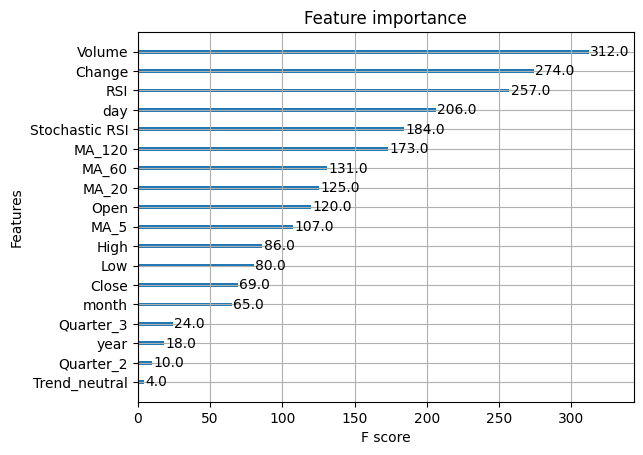

In [22]:
# 피처 중요도 시각화
import matplotlib.pyplot as plt

xgb.plot_importance(model)
plt.show()

In [20]:
# # 전체 데이터로 예측

# X = df_csv[['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'RSI',
#        'Stochastic RSI', 'year', 'month', 'day', 'Quarter_1',
#        'Quarter_2', 'Quarter_3', 'Quarter_4', 'Trend_down', 'Trend_neutral',
#        'Trend_up', 'MA_5', 'MA_20', 'MA_60', 'MA_120']]
# df_csv['Predicted_Target'] = model.predict(X)

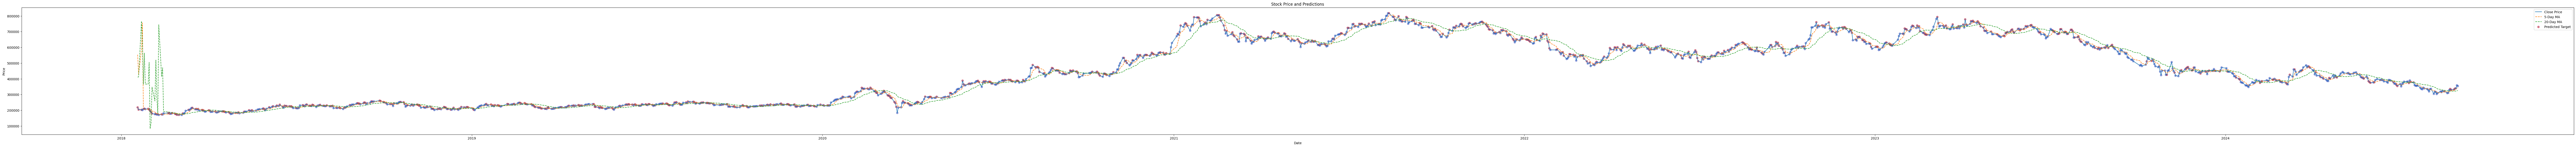

In [21]:
# # 시각화
# import matplotlib.pyplot as plt

# plt.figure(figsize=(140, 7))
# plt.plot(df_csv['Date'], df_csv['Close'], label='Close Price')
# plt.plot(df_csv['Date'], df_csv['MA_5'], label='5-Day MA', linestyle='--')
# plt.plot(df_csv['Date'], df_csv['MA_20'], label='20-Day MA', linestyle='--')
# plt.scatter(df_csv['Date'], df_csv['Close'], c=df_csv['Predicted_Target'], cmap='coolwarm', label='Predicted Target', alpha=0.5)
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('Stock Price and Predictions')
# plt.legend()
# plt.show()

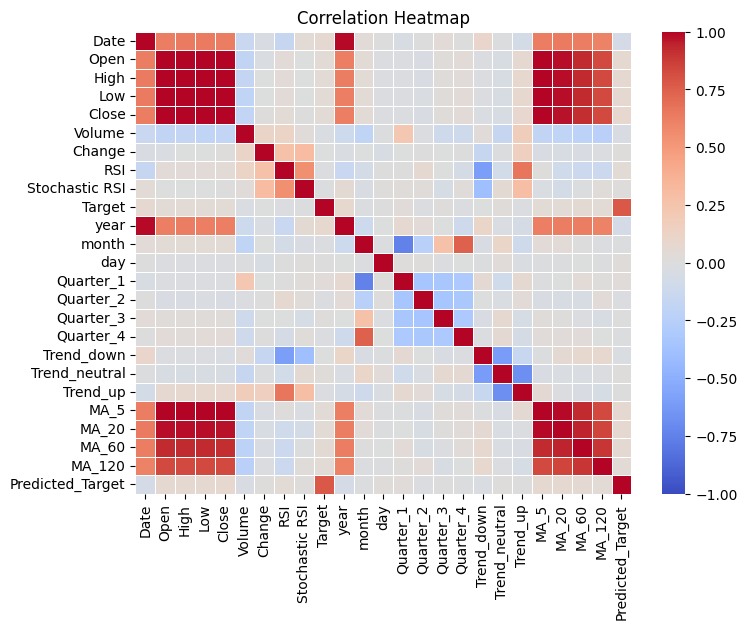

In [24]:
import seaborn as sns

# 상관관계 계산
corr = df_csv.corr()

# 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

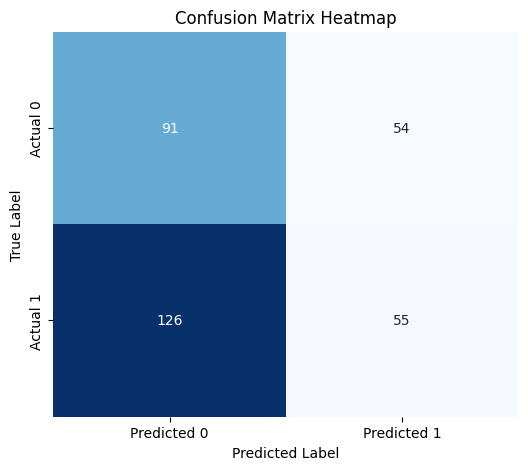

In [25]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_te, y_pred)

# 히트맵으로 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()